https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-10-02 00:12:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   168MB/s    in 0.4s    

2021-10-02 00:12:02 (168 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 5.5 MB/s 


In [ ]:
import os 
import zipfile 
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras import layers 
from tensorflow.keras import Model 

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D



In [4]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

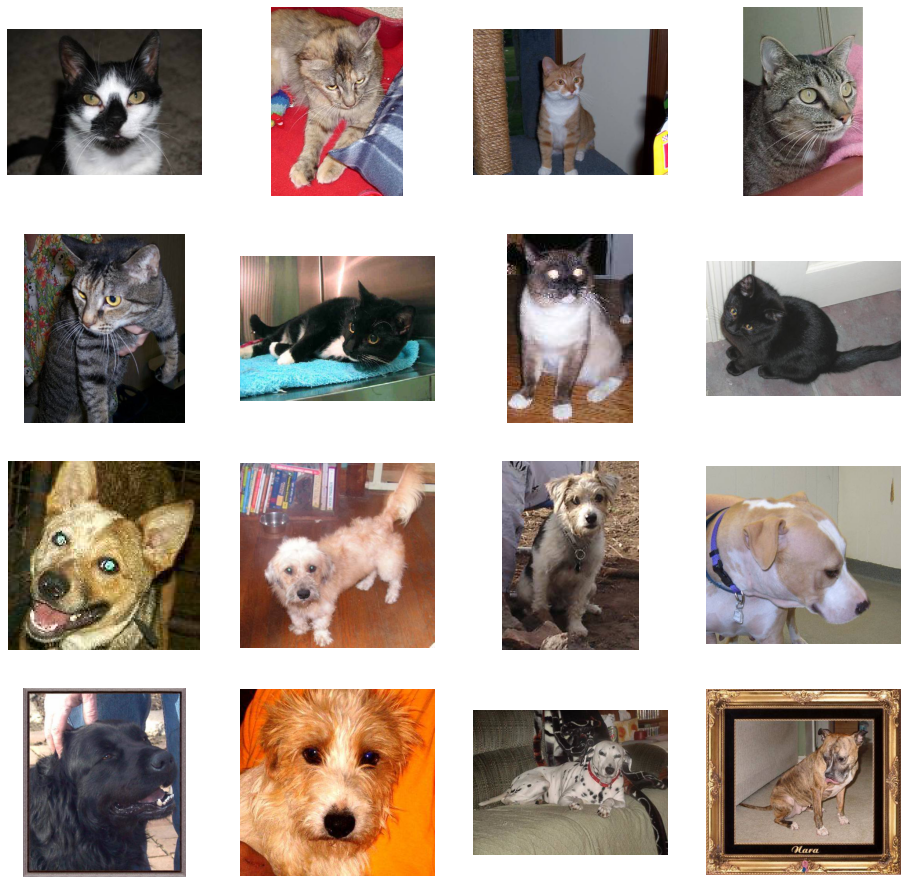

In [5]:
# Set up matplotlib fig, and size it to fit 4x4 pics
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()              

# VGG-16

In [6]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [7]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [11]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 48s 286ms/step - loss: 0.7225 - acc: 0.6620 - val_loss: 0.3644 - val_acc: 0.8350
Epoch 2/10
100/100 [==============================] - 28s 281ms/step - loss: 0.4726 - acc: 0.7780 - val_loss: 0.2462 - val_acc: 0.9020
Epoch 3/10
100/100 [==============================] - 28s 279ms/step - loss: 0.4231 - acc: 0.8120 - val_loss: 0.2406 - val_acc: 0.9010
Epoch 4/10
100/100 [==============================] - 28s 280ms/step - loss: 0.3861 - acc: 0.8230 - val_loss: 0.2722 - val_acc: 0.8850
Epoch 5/10
100/100 [==============================] - 28s 281ms/step - loss: 0.3684 - acc: 0.8400 - val_loss: 0.2045 - val_acc: 0.9160
Epoch 6/10
100/100 [==============================] - 29s 286ms/step - loss: 0.3461 - acc: 0.8465 - val_loss: 0.2051 - val_acc: 0.9200
Epoch 7/10
100/100 [==============================] - 30s 298ms/step - loss: 0.3223 - acc: 0.8555 - val_loss: 0.2001 - val_acc: 0.9230
Epoch 8/10
100/100 [==============================] - 2

# Inception

In [12]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [13]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
base_model.output

<KerasTensor: shape=(None, 3, 3, 2048) dtype=float32 (created by layer 'mixed10')>

In [17]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 24s 192ms/step - loss: 1.3008 - acc: 0.8365 - val_loss: 0.8113 - val_acc: 0.7860
Epoch 2/10
100/100 [==============================] - 18s 182ms/step - loss: 0.3770 - acc: 0.8830 - val_loss: 0.9784 - val_acc: 0.8310
Epoch 3/10
100/100 [==============================] - 18s 181ms/step - loss: 0.3378 - acc: 0.9025 - val_loss: 0.1748 - val_acc: 0.9460
Epoch 4/10
100/100 [==============================] - 18s 180ms/step - loss: 0.3058 - acc: 0.9105 - val_loss: 0.2879 - val_acc: 0.9250
Epoch 5/10
100/100 [==============================] - 18s 178ms/step - loss: 0.3507 - acc: 0.8990 - val_loss: 0.1472 - val_acc: 0.9520
Epoch 6/10
100/100 [==============================] - 18s 180ms/step - loss: 0.2941 - acc: 0.9170 - val_loss: 0.1373 - val_acc: 0.9570
Epoch 7/10
100/100 [==============================] - 18s 181ms/step - loss: 0.3366 - acc: 0.9130 - val_loss: 0.1182 - val_acc: 0.9550
Epoch 8/10
100/100 [==============================] - 1

# ResNet50

In [60]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [63]:
base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [64]:
for layer in base_model.layers:
    layer.trainable = False

In [56]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [57]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [61]:
# Alternate Method
#base_model = Sequential()
#base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
#base_model.add(Dense(1, activation='sigmoid'))

In [65]:
base_model.compile(optimizer = SGD(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])
#base_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])


In [66]:
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


InvalidArgumentError: ignored

# EfficientNet

In [67]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [68]:
base_model = EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [69]:
for layer in base_model.layers:
    layer.trainable = False

In [70]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'top_activation')>

In [71]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [74]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(input = base_model.input, output = predictions)

ValueError: ignored

In [ ]:
model_final.compile(optimizers.rmsprop(learning_rate=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)